# Importing libraries and loading data

In [1]:
import tensorflow as tf
import xgboost as xgb
import xgboost
import tensorflow
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras import initializers
from keras.wrappers.scikit_learn import KerasRegressor
from datetime import datetime as dt
from utils import *
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from data.features_engineering import TIME_SERIES_FEATURES_ENGINEERING
import sklearn
start=dt.now()

Using TensorFlow backend.


# Process weathertypes, remove empty windspeed and store (ignore if it's already done)

In [2]:
#If you want to generate the one_hot file uncomment the last line of this cell
def update_one_hot_data(combined_path,weather_combined_path):
    if not check_if_the_tsv_hot_file_already_has_processed_columns(weather_combined_path):        
        
        df = pd.read_csv(combined_path,
                         sep='\t',
                         header=0) 
        weather_unique_combinations = df.weather_condition.unique()

        #Get list of all unique weather types
        types = []
        for el in weather_unique_combinations:
            for wc in el.split('.'):
                if(wc != ''):            
                    types.append(wc.strip())
        true_unique =  set(types)

        #Add columns with default value 0 for all unique weather types
        for unique_weather_type in true_unique:
            df[unique_weather_type]=0

        #Loop over all records and set value to 1 for their corresponding weather_types
        for index, row in df.iterrows():
            row_types = []
            for wc in row["weather_condition"].split('.'):
                if(wc != ''):            
                    row_types.append(wc.strip())
            for t in row_types:
                df.at[index,t]=1


        #remove empty windspeeds
        df = df[df.wind_speed.apply(lambda x: str(x).isnumeric())]

        #remove original weather_condition column and store, to avoid rerun
        df =  df.drop(columns="weather_condition")
        df.to_csv(weather_combined_path,
                  sep='\t',
                  index=False,
                  header=True) 
        TIME_SERIES_FEATURES_ENGINEERING(weather_combined_path)
    else:
        print("File already processed.")
        
combined_path = "./data/combined_data.tsv"
weather_combined_path="./data/combined_one_hot_data.tsv"
#update_one_hot_data(combined_path,weather_combined_path)

# Loadin data with one_hot weather types

In [3]:
def select_data_from_lat_csv(data,latitude):

    return data[data['latitude']==latitude]
def obtain_latitudes_list(latitude_data):
    return latitude_data.unique()
weather_combined_path="./data/combined_one_hot_data.tsv"
df = pd.read_csv(weather_combined_path,
                 sep='\t',
                 header=0)
print(df.shape)
lat_list=obtain_latitudes_list(df.latitude)
pole=0
df=select_data_from_lat_csv(df,lat_list[pole])
print("Selecting data for bikes station on latitude "+str(lat_list[pole]))
#print(lat_list)
print(df.shape)

#choose one station to test on
#df=df[df['device_name']=='CB1143']
#print(df)

(101461, 48)
Selecting data for bikes station on latitude 50.85363
(15277, 48)


# Remove outliers (bike_count)

In [4]:
def remove_outlier(df_in, col_name):
    """Removes all outliers on a specific column from a given dataframe.

    Args:
        df_in (pandas.DataFrame): Iput pandas dataframe containing outliers
        col_name (str): Column name on which to search outliers

    Returns:
        pandas.DataFrame: DataFrame without outliers
    """         
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1  # Interquartile range
    fence_low = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    return df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)] 
start_size=df.shape[0]
df = remove_outlier(df, "bike_count")
print(df.shape)
print("We have removed "+str(start_size-df.shape[0])+" outliers tuples (which is "+str((start_size-df.shape[0])/start_size*100)+" % of total).")

(14422, 48)
We have removed 855 outliers tuples (which is 5.596648556653793 % of total).


# Correlation of variables


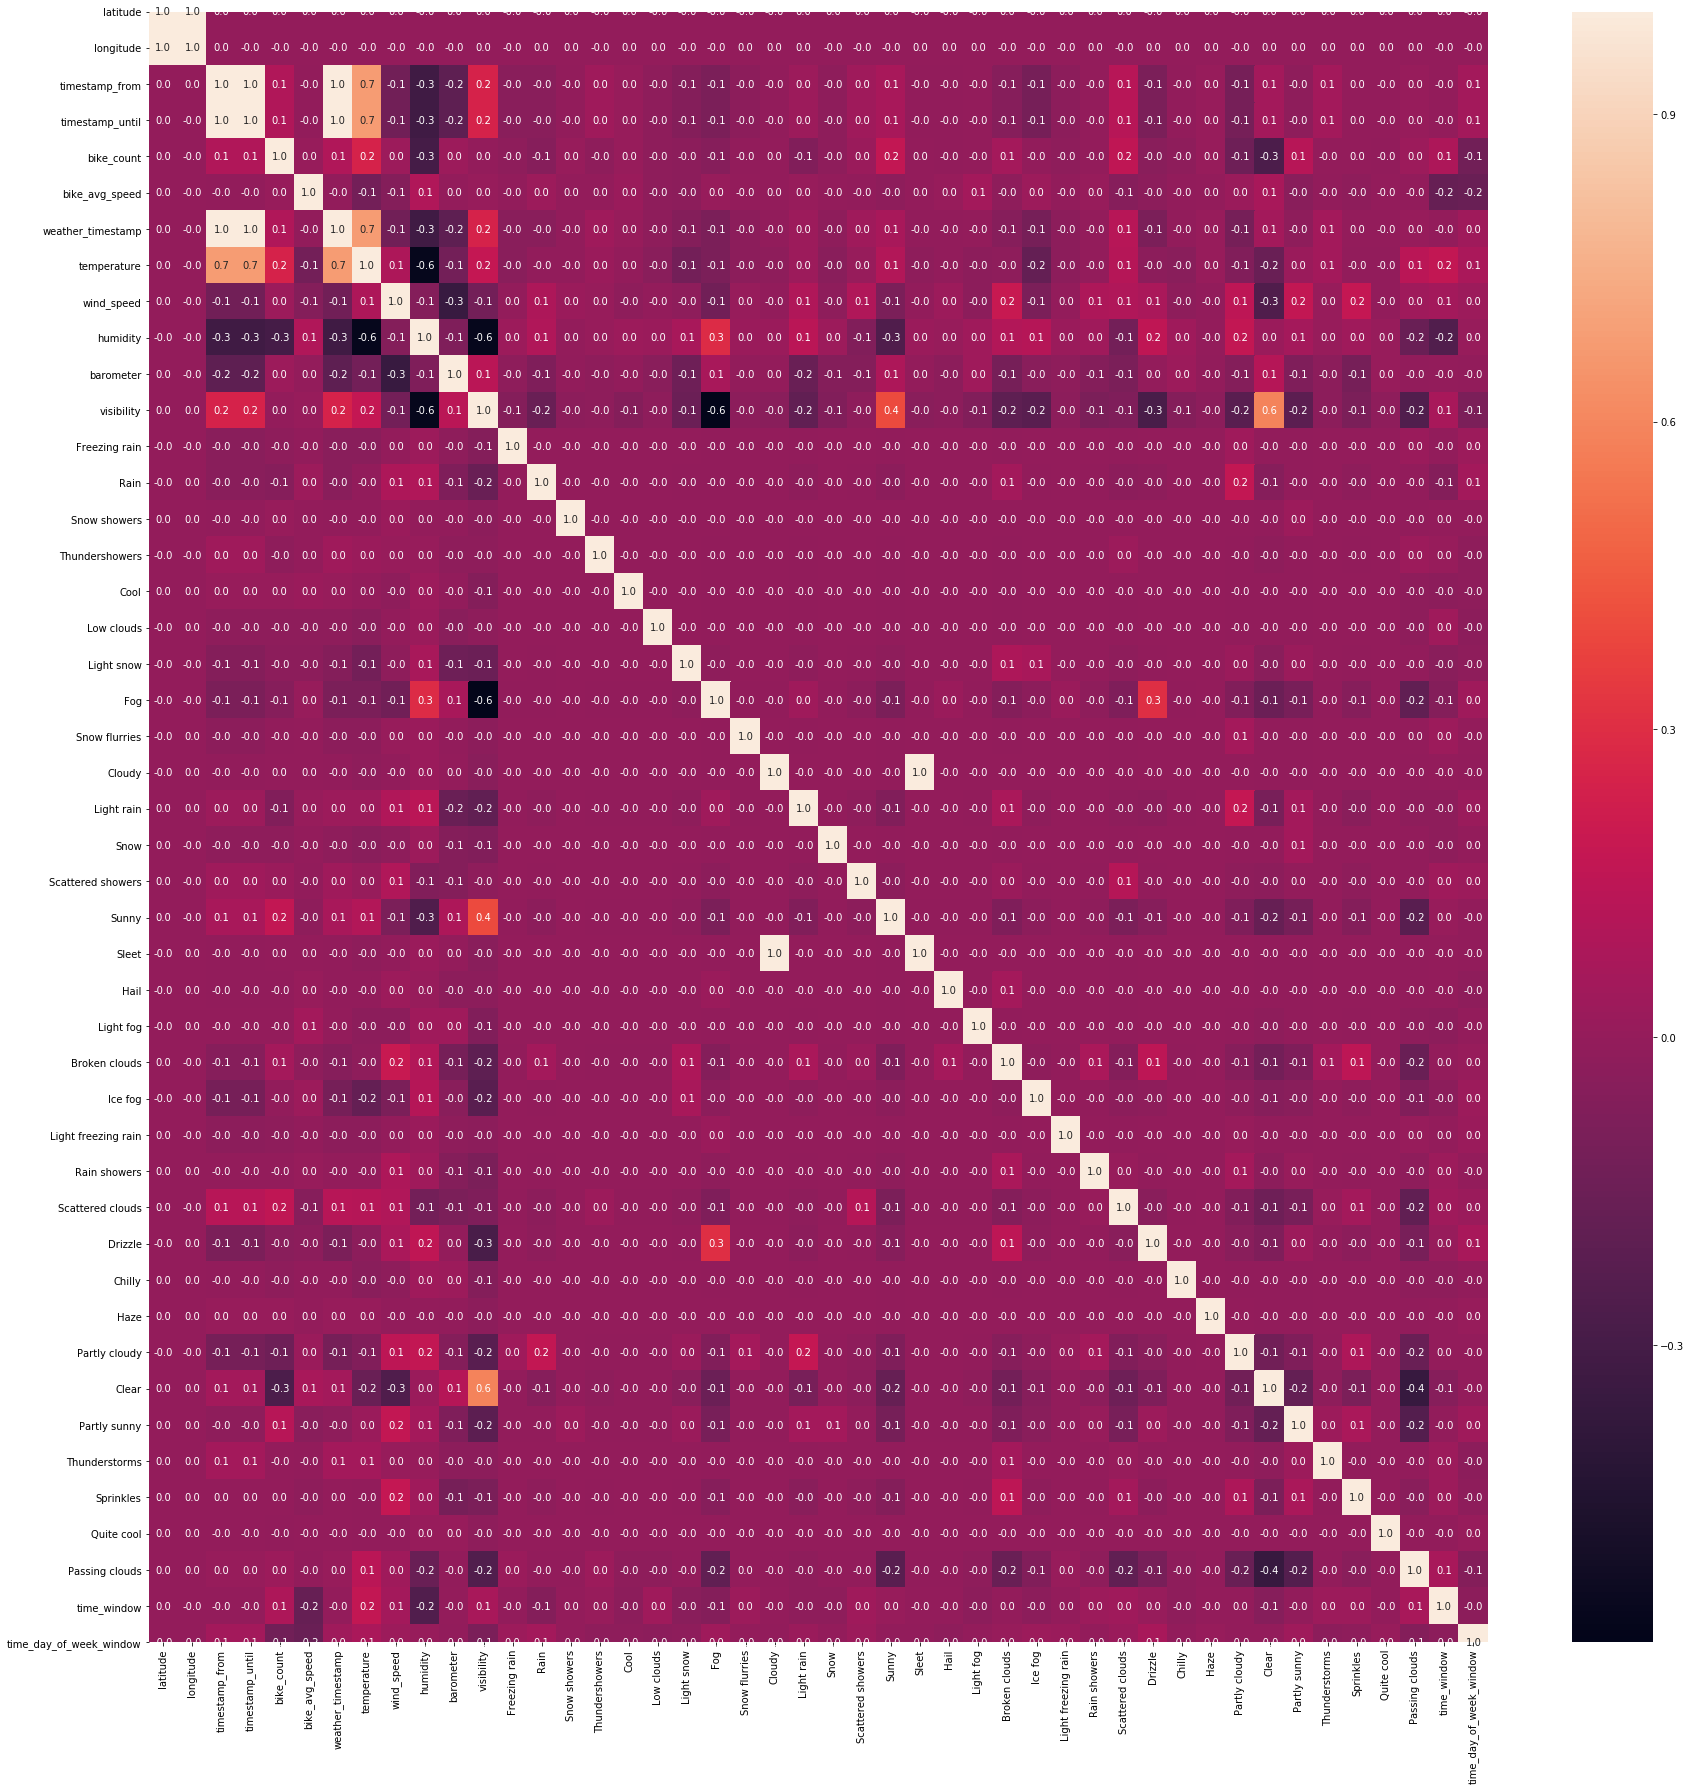

In [5]:
import matplotlib.pyplot as plt



fig, ax = plt.subplots(figsize=(30,30))    

correlation_matrix = df.corr().round(2)
#print(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, fmt=".001f",ax=ax)

# Feature selection

In [6]:
def remove_features(df):
    return df.drop(columns=[        
    'device_name',
    'timestamp_until',
    'bike_avg_speed',
    'weather_timestamp',
    'wind_direction',
    'wind_speed',
    'barometer',
    'visibility',
    'Ice fog',
    'Thundershowers',
    'Sprinkles',
    'Broken clouds',
    'Rain showers',
    'Snow flurries',
    'Light fog',
    'Sleet',
    'Cloudy',
    'Quite cool'    
])
def remove__weather_features(df):
    return df.drop(columns=[        
    'temperature',
    'humidity',
    'Scattered showers',
    'Low clouds',
    'Snow',
    'Snow showers',
    'Thunderstorms',
    'Partly sunny',
    'Light freezing rain',
    'Sunny',
    'Light rain',
    'Freezing rain',
    'Light snow',
    'Passing clouds',
    'Fog',
    'Cool',
    'Partly cloudy',
    'Haze',
    'Hail',
    'Scattered clouds',
    'Drizzle',
    'Clear',
    'Rain',
    'Chilly'    
        
])

df=remove_features(df)
#df=remove__weather_features(df)
#print(df.head())
print(df.shape)

(14422, 30)


# Build models

In [7]:
def build_normal_model():
    #look for regularization with keras 
    initializer = initializers.VarianceScaling(scale=1.0, mode='fan_in', distribution='normal', seed=None)
    model = Sequential()   
    
    model.add(Dense(28, input_dim=28,kernel_initializer='normal', activation='relu'))
    model.add(Dense(14,activation='relu'))    
    model.add(Dense(1, activation='relu'))
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mse','mae'])
    model.summary()
    return model

from sklearn.ensemble import RandomForestRegressor
def build_Random_forest_model():
    #model = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100)
    model = RandomForestRegressor()
    return model
def build_SVM_REGRESSION_model():
    model=SVR()
    return model
def build_XGBOOST_reg_model():
    model = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 300)
    return model
normal_model = build_normal_model()
#normal_model = build_Random_forest_model()
#normal_model=build_SVM_REGRESSION_model()
#normal_model=build_XGBOOST_reg_model()
model = normal_model

W0706 23:45:38.670235 4370150848 deprecation.py:573] From /Users/mactoweretro/deep_learning/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py:507: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with distribution=normal is deprecated and will be removed in a future version.
Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
W0706 23:45:38.684729 4370150848 deprecation.py:506] From /Users/mactoweretro/deep_learning/lib/python3.7/site-packages/tensorflow/python/keras/initializers.py:143: calling RandomNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0706 23:45:38.705986 4370150848 deprecation.py:506] From /Users/mactoweretro/deep_learning/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__in

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 28)                812       
_________________________________________________________________
dense_1 (Dense)              (None, 14)                406       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 15        
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________


# Defining model execution functions

In [8]:
def build_normal_model_grid_search(input_nodes,hidden_layer_nodes,init_kernel,optimizer,loss_item,activation_item):
    #look for regularization with keras 
    
    model = Sequential()   
    
    model.add(Dense(input_nodes, input_dim=28,kernel_initializer=init_kernel, activation=activation_item))
    model.add(Dense(hidden_layer_nodes,activation=activation_item))    
    model.add(Dense(1, activation=activation_item))    
    model.compile(loss=loss_item, optimizer=optimizer, metrics=['mse','mae'])
    model.summary()
    return model
def gridSearch_neural_network(X_train, y_train,baseline_model):
    input_layer_nodes=[2,28,56]
    hidden_layer_nodes=[2,14,56]
    glorot='glorot_uniform'
    init = ['normal', 'uniform']
    RMSprop = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    SGD=tf.keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)    
    Adam=tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)    
    optimizer_list=[RMSprop,SGD,Adam]
    
    mean_squared_error="mean_squared_error"
    mean_absolute_error="mean_absolute_error"         
    hinge="hinge"
    
    losses_f_list=[mean_squared_error,mean_absolute_error]
        
    activation_list=['softmax','relu','linear']
    
    num_inodes=input_layer_nodes[0]
    num_hnodes=hidden_layer_nodes[0]
    init_kernel_name=init[0]
    optimizer_alg=optimizer_list[0]
    loss_function_f=losses_f_list[0]
    activation_f=activation_list[0]
    best_performance=1000
    
    historical_performance_list=[]
    counter=0
    for inodes in input_layer_nodes:
        for hnodes in hidden_layer_nodes:
            for init_k in init:
                for opt in optimizer_list:
                    for loss_item in losses_f_list:
                        for activation_item in activation_list:                            
                            for i in range(0,1):
                                baseline_model=build_normal_model_grid_search(inodes,hnodes,init_k,opt,loss_item,activation_item)
                                history=baseline_model.fit(X_train, y_train,epochs=25,verbose=0)
                                counter+=1
                                                                
                                if best_performance > history.history['mean_squared_error'][len(history.history['mean_squared_error'])-1]:
                                    best_performance = history.history['mean_squared_error'][len(history.history['mean_squared_error'])-1]
                                    num_inodes=inodes
                                    num_hnodes=hnodes
                                    init_kernel_name=init_k
                                    optimizer_alg=opt
                                    loss_function_f=loss_item
                                    activation_f=activation_item
                                    print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
                                    print(history.history['mean_squared_error'])
                                    print("We have a new BEST PERFORMANCE: "+str(best_performance))
                                    print("num input nodes "+str(num_inodes))
                                    print("num idden layer nodes: "+str(num_hnodes))
                                    print("init kernel name: "+str(init_kernel_name))
                                    print("optimizer algorith: "+str(optimizer_alg))
                                    print("loss function: "+str(loss_function_f))
                                    print("activation function: "+str(activation_f))
                                    print("COUNTER= "+str(counter))
                                    historical_performance_list.append([counter,best_performance])
                                    print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")

                    
    print("*****************************************************")
    print("FINALLY OUR BEST PERFORMANCE: "+str(best_performance))
    print(num_inodes)
    print(num_hnodes)
    print(init_kernel_name)
    print(optimizer_alg)
    print(loss_function_f)
    print(activation_f)
    print("***************************************************************************")
    print("historical_performance_list:")
    print(historical_performance_list)
    print("***************************************************************************")
    
    ''' evaluate model with standardized dataset
    estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=5, verbose=0)
    
    # grid search epochs, batch size and optimizer
    optimizers = ['rmsprop', 'adam']
    dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    
    epochs = [50, 100, 150]
    batches = [5, 10, 20]
    weight_constraint = [1, 2, 3, 4, 5]
    param_grid = dict(optimizer=optimizers, 
                      dropout_rate=dropout_rate, 
                      epochs=epochs, 
                      batch_size=batches, 
                      weight_constraint=weight_constraint, 
                      init=init)
    '''
    

def save_model(dataFrame,model_name,min_value,max_value):
    import pickle
    file_name_string='./data/model_data_prediction/'+model_name+"_predictions"
    if min_value!=None or max_value!=None:
        file_name_string+="_from_"+str(min_value)+"_to_"+str(max_value)
    file_name_string+=".bin"
    print("this is the filename string")
    print("Saving model on "+file_name_string)
   
    dataFrame[min_value:max_value].to_pickle(file_name_string)
def execute_Sequential_model(model,df):
    df.set_index('timestamp_from', inplace=True)
    df = df.sort_values(by=['timestamp_from'])

    #set bike_count as Y
    df_y = df.bike_count
    df_x = df.drop(columns="bike_count")
    #Normalization
    x = df_x.values
    y = df_y.values.reshape(-1, 1)

    x_scaler = preprocessing.MinMaxScaler()
    x_normalized = x_scaler.fit_transform(x)

    y_scaler = preprocessing.MinMaxScaler()
    y_normalized = y_scaler.fit_transform(y)

    x_in = pd.DataFrame(x_normalized)
    y_in = pd.DataFrame(y_normalized)


    #Prepare train & test dataset
    test_size = 0.2
    total = x_in.shape[0]
    train_idx = round((1-test_size) * total)



    x_train = x_in[0:train_idx].values
    #x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])

    x_test = x_in[train_idx+1:total-1].values
    #x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

    y_train = y_in[0:train_idx].values
    y_test = y_in[train_idx+1:total-1]



    print("x_train shape {}".format(x_train.shape))
    print("y_train shape {}".format(y_train.shape))
    def show_loss_graph(hist,variable):
        plt.plot(history.history[variable])    
        plt.title('model '+variable)
        plt.ylabel(variable)
        plt.xlabel('epoch')
        plt.legend(['train '+variable], loc='upper left')
        plt.show()
        
    gridSearch_neural_network(x_train, y_train,model)
    
    
    history=model.fit(x_train, y_train,epochs=100)
    
    model.save('./model/model-23-jun.bin')
    show_loss_graph(history,"loss")
    show_loss_graph(history,"mean_squared_error")
    def evaluate_model_and_show_graph(x_test,y_test,model,min_value=None,max_value=None):
        model.evaluate(x_test, y_test)
        y_prediction = model.predict(x_test)
        print(y_prediction)
        y_pred_scaled = y_scaler.inverse_transform(y_prediction)
        y_test_scaled = y_scaler.inverse_transform(y_test)
        mse = mean_squared_error(y_pred_scaled[min_value:max_value], y_test_scaled[min_value:max_value])
        mae=mean_absolute_error(y_pred_scaled[min_value:max_value], y_test_scaled[min_value:max_value])
        print("MSE: "+str(mse))
        print("MAE: "+str(mae))
        plt.rcParams['figure.figsize'] = [18, 18]
        #---SAVING PREDICTIONS DATAFRAME
        pred_df=pd.DataFrame(y_pred_scaled)     
        y_test_df=pd.DataFrame(y_test_scaled)          
        save_model(pred_df,'FNN',min_value,max_value)
        
        '''y_test_df=y_test.reset_index(inplace=False)  
        y_test_df=y_test_df.drop(columns="timestamp_from")
        save_model(y_test_df,'Ground_t',min_value,max_value)'''
        #---END SAVING PREDICTIONS DATAFRAME   
        l1, = plt.plot(y_test_scaled[min_value:max_value], 'g')
        l2, = plt.plot(pred_df[min_value:max_value] ,'r', alpha=0.7)
        plt.legend(['Ground truth', 'Predicted'])
        plt.show()
    evaluate_model_and_show_graph(x_test,y_test,model)
    update_one_hot_data('./data/combined_data_22-jun.tsv','./data/combined_data_22-jun_one_hot_data.tsv')
    df_new_data = pd.read_csv('./data/combined_data_22-jun_one_hot_data.tsv',
                     sep='\t',
                     header=0)
    start_size=df_new_data.shape[0]
    print(df_new_data.shape)
    df_new_data = remove_outlier(df_new_data, "bike_count")
    print("We have removed "+str(start_size-df_new_data.shape[0])+" outliers tuples (which is "+str((start_size-df_new_data.shape[0])/start_size*100)+" % of total).")
    df_new_data=remove_features(df_new_data)    
    df_new_data.set_index('timestamp_from', inplace=True)
    df_new_data = df_new_data.sort_values(by=['timestamp_from'])
    print(df_new_data.shape)


    #set bike_count as Y
    df_y = df_new_data.bike_count
    df_x = df_new_data.drop(columns="bike_count")


    #Normalization
    x = df_x.values
    y = df_y.values.reshape(-1, 1)

    x_scaler = preprocessing.MinMaxScaler()
    x_normalized = x_scaler.fit_transform(x)

    y_scaler = preprocessing.MinMaxScaler()
    y_normalized = y_scaler.fit_transform(y)

    x_in = pd.DataFrame(x_normalized)
    y_in = pd.DataFrame(y_normalized)
    #this line is commented in order to obtain the correct .bin data on data/data_model_prediction
    #evaluate_model_and_show_graph(x_in,y_in,model)
    print("You are running a Sequential model")
    return model
def execute_Random_forest_model(model,df_x,df_y):   
    model.fit(df_x, df_y)
    print("You are running a RandomForest model")
    return model
def execute_SVM_regression_model(model,df_x,df_y):
    model.fit(df_x, df_y)
    print("You are running a SVM-Regression model")
    return model
def execute_XGBOOST_model(model,df_x,df_y):
    model.fit(df_x, df_y)
    print("You are running a XGBOOST model")
    return model
    
    

# Running models

In [ ]:
x_test=None
y_test=None
print(df.shape)
print(type(model))
#input()
def EXECUTE_MODEL(model,df):
    if isinstance(model,sklearn.ensemble.forest.RandomForestRegressor):
        df.set_index('timestamp_from', inplace=True)
        df = df.sort_values(by=['timestamp_from'])
        #set bike_count as Y
        df_y = df.bike_count
        df_x = df.drop(columns="bike_count")
        #Prepare train & test dataset
        test_size = 0.2
        total = df_x.shape[0]
        train_idx = round((1-test_size) * total)



        x_train = df_x[0:train_idx].values
        #x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
        global x_test
        global y_test

        x_test = df_x[train_idx+1:total-1].values
        #x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

        y_train = df_y[0:train_idx].values
        y_test = df_y[train_idx+1:total-1]
        return execute_Random_forest_model(model,x_train,y_train)
    if isinstance(model,sklearn.svm.classes.SVR):
        df.set_index('timestamp_from', inplace=True)
        df = df.sort_values(by=['timestamp_from'])
        #set bike_count as Y
        df_y = df.bike_count
        df_x = df.drop(columns="bike_count")
        #Prepare train & test dataset
        test_size = 0.2
        total = df_x.shape[0]
        train_idx = round((1-test_size) * total)



        x_train = df_x[0:train_idx].values
        #x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
             

        x_test = df_x[train_idx+1:total-1].values
        #x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

        y_train = df_y[0:train_idx].values
        y_test = df_y[train_idx+1:total-1]        
        return execute_SVM_regression_model(model,x_train,y_train)
    if isinstance(model,xgboost.sklearn.XGBRegressor):
        df.set_index('timestamp_from', inplace=True)
        df = df.sort_values(by=['timestamp_from'])
        #set bike_count as Y
        df_y = df.bike_count
        df_x = df.drop(columns="bike_count")
        #Prepare train & test dataset
        test_size = 0.2
        total = df_x.shape[0]
        train_idx = round((1-test_size) * total)



        x_train = df_x[0:train_idx].values
        #x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
        

        x_test = df_x[train_idx+1:total-1].values
        #x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

        y_train = df_y[0:train_idx].values
        y_test = df_y[train_idx+1:total-1]
        return execute_XGBOOST_model(model,x_train,y_train)        
    else:
        return execute_Sequential_model(model,df)
    
    
#print(type(model))
#print(df)
model=EXECUTE_MODEL(model,df)

(14422, 30)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
x_train shape (11538, 28)
y_train shape (11538, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 2)                 58        
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 3         
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
[0.6137339, 0.61373436, 0.6137344, 0.61373407, 0.6137338, 0.61373454, 0.6137343, 0.6137339, 0.61373425, 0.6137343, 0.61373454, 0.61373425, 0.6137342, 0.6137341, 0.6137341, 0.61373425, 0.6137342, 0.6137341, 

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 2)                 58        
_________________________________________________________________
dense_31 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 3         
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 2)                 58        
_________________________________________________________________
dense_34 (Dense)             (None, 2)                 6         
__________________________________

W0706 23:48:24.979238 4370150848 deprecation.py:323] From /Users/mactoweretro/deep_learning/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 2)                 58        
_________________________________________________________________
dense_58 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 3         
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 2)                 58        
_________________________________________________________________
dense_61 (Dense)             (None, 2)                 6         
__________________________________

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_90 (Dense)             (None, 2)                 58        
_________________________________________________________________
dense_91 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_92 (Dense)             (None, 1)                 3         
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_93 (Dense)             (None, 2)                 58        
_________________________________________________________________
dense_94 (Dense)             (None, 2)                 6         
__________________________________

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_123 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_124 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_125 (Dense)            (None, 1)                 3         
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_126 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_127 (Dense)            (None, 2)                 6         
__________________________________

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_156 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_157 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_158 (Dense)            (None, 1)                 3         
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_159 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_160 (Dense)            (None, 2)                 6         
__________________________________

Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_189 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_190 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_191 (Dense)            (None, 1)                 3         
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_192 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_193 (Dense)            (None, 2)                 6         
__________________________________

Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_222 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_223 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_224 (Dense)            (None, 1)                 3         
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_225 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_226 (Dense)            (None, 2)                 6         
__________________________________

Model: "sequential_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_255 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_256 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_257 (Dense)            (None, 1)                 3         
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_258 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_259 (Dense)            (None, 2)                 6         
__________________________________

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
[0.050019264, 0.04525737, 0.044591714, 0.043935582, 0.043418035, 0.04265561, 0.041244604, 0.04036926, 0.039886955, 0.039295334, 0.03915446, 0.038718674, 0.038684417, 0.03870953, 0.03850723, 0.038744055, 0.0385111, 0.038420662, 0.0385853, 0.038495954, 0.038461603, 0.03836206, 0.038506817, 0.038298015, 0.03849389]
We have a new BEST PERFORMANCE: 0.03849389
num input nodes 2
num idden layer nodes: 2
init kernel name: normal
optimizer algorith: <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x13a94d320>
loss function: mean_absolute_error
activation function: relu
COUNTER= 95
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_288 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_

Model: "sequential_107"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_321 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_322 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_323 (Dense)            (None, 1)                 3         
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_108"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_324 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_325 (Dense)            (None, 2)                 6         
________________________________

Model: "sequential_118"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_354 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_355 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_356 (Dense)            (None, 1)                 3         
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_119"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_357 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_358 (Dense)            (None, 2)                 6         
________________________________

Model: "sequential_129"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_387 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_388 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_389 (Dense)            (None, 1)                 3         
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_130"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_390 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_391 (Dense)            (None, 2)                 6         
________________________________

Model: "sequential_140"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_420 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_421 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_422 (Dense)            (None, 1)                 3         
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
[0.046808057, 0.043080274, 0.042568088, 0.041948754, 0.039044574, 0.03818233, 0.03764131, 0.037278812, 0.036940012, 0.036582764, 0.03596072, 0.035529524, 0.035276324, 0.034939073, 0.034807846, 0.034644697, 0.034601536, 0.034492012, 0.03445536, 0.034393784, 0.03431474, 0.034313675, 0.03426269, 0.034246102, 0.03420881]
We have a n

Model: "sequential_151"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_453 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_454 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_455 (Dense)            (None, 1)                 3         
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_152"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_456 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_457 (Dense)            (None, 2)                 6         
________________________________

Model: "sequential_162"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_486 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_487 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_488 (Dense)            (None, 1)                 3         
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________


W0707 00:25:28.961256 4370150848 deprecation.py:506] From /Users/mactoweretro/deep_learning/lib/python3.7/site-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential_163"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_489 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_490 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_491 (Dense)            (None, 1)                 3         
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_164"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_492 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_493 (Dense)            (None, 2)                 6         
________________________________

Model: "sequential_174"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_522 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_523 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_524 (Dense)            (None, 1)                 3         
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_175"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_525 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_526 (Dense)            (None, 2)                 6         
________________________________

Model: "sequential_185"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_555 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_556 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_557 (Dense)            (None, 1)                 3         
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_186"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_558 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_559 (Dense)            (None, 2)                 6         
________________________________

Model: "sequential_196"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_588 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_589 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_590 (Dense)            (None, 1)                 3         
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_197"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_591 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_592 (Dense)            (None, 2)                 6         
________________________________

Model: "sequential_207"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_621 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_622 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_623 (Dense)            (None, 1)                 3         
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_208"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_624 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_625 (Dense)            (None, 2)                 6         
________________________________

Model: "sequential_218"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_654 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_655 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_656 (Dense)            (None, 1)                 3         
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_219"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_657 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_658 (Dense)            (None, 2)                 6         
________________________________

Model: "sequential_229"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_687 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_688 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_689 (Dense)            (None, 1)                 3         
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_230"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_690 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_691 (Dense)            (None, 2)                 6         
________________________________

Model: "sequential_240"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_720 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_721 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_722 (Dense)            (None, 1)                 3         
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_241"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_723 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_724 (Dense)            (None, 2)                 6         
________________________________

Model: "sequential_251"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_753 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_754 (Dense)            (None, 14)                42        
_________________________________________________________________
dense_755 (Dense)            (None, 1)                 15        
Total params: 115
Trainable params: 115
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_252"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_756 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_757 (Dense)            (None, 14)                42        
______________________________

Model: "sequential_262"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_786 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_787 (Dense)            (None, 14)                42        
_________________________________________________________________
dense_788 (Dense)            (None, 1)                 15        
Total params: 115
Trainable params: 115
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_263"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_789 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_790 (Dense)            (None, 14)                42        
______________________________

Model: "sequential_273"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_819 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_820 (Dense)            (None, 14)                42        
_________________________________________________________________
dense_821 (Dense)            (None, 1)                 15        
Total params: 115
Trainable params: 115
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_274"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_822 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_823 (Dense)            (None, 14)                42        
______________________________

Model: "sequential_284"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_852 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_853 (Dense)            (None, 14)                42        
_________________________________________________________________
dense_854 (Dense)            (None, 1)                 15        
Total params: 115
Trainable params: 115
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_285"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_855 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_856 (Dense)            (None, 14)                42        
______________________________

Model: "sequential_295"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_885 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_886 (Dense)            (None, 14)                42        
_________________________________________________________________
dense_887 (Dense)            (None, 1)                 15        
Total params: 115
Trainable params: 115
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_296"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_888 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_889 (Dense)            (None, 14)                42        
______________________________

Model: "sequential_306"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_918 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_919 (Dense)            (None, 14)                42        
_________________________________________________________________
dense_920 (Dense)            (None, 1)                 15        
Total params: 115
Trainable params: 115
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_307"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_921 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_922 (Dense)            (None, 14)                42        
______________________________

Model: "sequential_317"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_951 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_952 (Dense)            (None, 14)                42        
_________________________________________________________________
dense_953 (Dense)            (None, 1)                 15        
Total params: 115
Trainable params: 115
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_318"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_954 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_955 (Dense)            (None, 14)                42        
______________________________

Model: "sequential_328"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_984 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_985 (Dense)            (None, 14)                42        
_________________________________________________________________
dense_986 (Dense)            (None, 1)                 15        
Total params: 115
Trainable params: 115
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_329"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_987 (Dense)            (None, 2)                 58        
_________________________________________________________________
dense_988 (Dense)            (None, 14)                42        
______________________________

Model: "sequential_339"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1017 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1018 (Dense)           (None, 14)                42        
_________________________________________________________________
dense_1019 (Dense)           (None, 1)                 15        
Total params: 115
Trainable params: 115
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_340"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1020 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1021 (Dense)           (None, 14)                42        
______________________________

Model: "sequential_350"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1050 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1051 (Dense)           (None, 14)                42        
_________________________________________________________________
dense_1052 (Dense)           (None, 1)                 15        
Total params: 115
Trainable params: 115
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_351"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1053 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1054 (Dense)           (None, 14)                42        
______________________________

Model: "sequential_361"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1083 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1084 (Dense)           (None, 14)                42        
_________________________________________________________________
dense_1085 (Dense)           (None, 1)                 15        
Total params: 115
Trainable params: 115
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_362"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1086 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1087 (Dense)           (None, 14)                42        
______________________________

Model: "sequential_372"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1116 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1117 (Dense)           (None, 14)                42        
_________________________________________________________________
dense_1118 (Dense)           (None, 1)                 15        
Total params: 115
Trainable params: 115
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_373"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1119 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1120 (Dense)           (None, 14)                42        
______________________________

Model: "sequential_383"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1149 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1150 (Dense)           (None, 14)                42        
_________________________________________________________________
dense_1151 (Dense)           (None, 1)                 15        
Total params: 115
Trainable params: 115
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_384"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1152 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1153 (Dense)           (None, 14)                42        
______________________________

Model: "sequential_394"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1182 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1183 (Dense)           (None, 14)                42        
_________________________________________________________________
dense_1184 (Dense)           (None, 1)                 15        
Total params: 115
Trainable params: 115
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_395"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1185 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1186 (Dense)           (None, 14)                42        
______________________________

Model: "sequential_405"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1215 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1216 (Dense)           (None, 14)                42        
_________________________________________________________________
dense_1217 (Dense)           (None, 1)                 15        
Total params: 115
Trainable params: 115
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_406"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1218 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1219 (Dense)           (None, 14)                42        
______________________________

Model: "sequential_416"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1248 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1249 (Dense)           (None, 14)                42        
_________________________________________________________________
dense_1250 (Dense)           (None, 1)                 15        
Total params: 115
Trainable params: 115
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_417"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1251 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1252 (Dense)           (None, 14)                42        
______________________________

Model: "sequential_426"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1278 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1279 (Dense)           (None, 14)                42        
_________________________________________________________________
dense_1280 (Dense)           (None, 1)                 15        
Total params: 115
Trainable params: 115
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_427"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1281 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1282 (Dense)           (None, 14)                42        
______________________________

Model: "sequential_437"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1311 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1312 (Dense)           (None, 14)                42        
_________________________________________________________________
dense_1313 (Dense)           (None, 1)                 15        
Total params: 115
Trainable params: 115
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_438"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1314 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1315 (Dense)           (None, 14)                42        
______________________________

Model: "sequential_448"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1344 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1345 (Dense)           (None, 14)                42        
_________________________________________________________________
dense_1346 (Dense)           (None, 1)                 15        
Total params: 115
Trainable params: 115
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_449"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1347 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1348 (Dense)           (None, 14)                42        
______________________________

Model: "sequential_459"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1377 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1378 (Dense)           (None, 14)                42        
_________________________________________________________________
dense_1379 (Dense)           (None, 1)                 15        
Total params: 115
Trainable params: 115
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_460"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1380 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1381 (Dense)           (None, 14)                42        
______________________________

Model: "sequential_470"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1410 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1411 (Dense)           (None, 14)                42        
_________________________________________________________________
dense_1412 (Dense)           (None, 1)                 15        
Total params: 115
Trainable params: 115
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_471"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1413 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1414 (Dense)           (None, 14)                42        
______________________________

Model: "sequential_481"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1443 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1444 (Dense)           (None, 14)                42        
_________________________________________________________________
dense_1445 (Dense)           (None, 1)                 15        
Total params: 115
Trainable params: 115
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_482"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1446 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1447 (Dense)           (None, 14)                42        
______________________________

Model: "sequential_492"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1476 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1477 (Dense)           (None, 56)                168       
_________________________________________________________________
dense_1478 (Dense)           (None, 1)                 57        
Total params: 283
Trainable params: 283
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_493"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1479 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1480 (Dense)           (None, 56)                168       
______________________________

Model: "sequential_503"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1509 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1510 (Dense)           (None, 56)                168       
_________________________________________________________________
dense_1511 (Dense)           (None, 1)                 57        
Total params: 283
Trainable params: 283
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_504"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1512 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1513 (Dense)           (None, 56)                168       
______________________________

Model: "sequential_514"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1542 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1543 (Dense)           (None, 56)                168       
_________________________________________________________________
dense_1544 (Dense)           (None, 1)                 57        
Total params: 283
Trainable params: 283
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_515"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1545 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1546 (Dense)           (None, 56)                168       
______________________________

Model: "sequential_525"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1575 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1576 (Dense)           (None, 56)                168       
_________________________________________________________________
dense_1577 (Dense)           (None, 1)                 57        
Total params: 283
Trainable params: 283
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_526"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1578 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1579 (Dense)           (None, 56)                168       
______________________________

Model: "sequential_536"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1608 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1609 (Dense)           (None, 56)                168       
_________________________________________________________________
dense_1610 (Dense)           (None, 1)                 57        
Total params: 283
Trainable params: 283
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_537"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1611 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1612 (Dense)           (None, 56)                168       
______________________________

Model: "sequential_547"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1641 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1642 (Dense)           (None, 56)                168       
_________________________________________________________________
dense_1643 (Dense)           (None, 1)                 57        
Total params: 283
Trainable params: 283
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_548"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1644 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1645 (Dense)           (None, 56)                168       
______________________________

Model: "sequential_558"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1674 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1675 (Dense)           (None, 56)                168       
_________________________________________________________________
dense_1676 (Dense)           (None, 1)                 57        
Total params: 283
Trainable params: 283
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_559"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1677 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1678 (Dense)           (None, 56)                168       
______________________________

Model: "sequential_569"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1707 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1708 (Dense)           (None, 56)                168       
_________________________________________________________________
dense_1709 (Dense)           (None, 1)                 57        
Total params: 283
Trainable params: 283
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_570"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1710 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1711 (Dense)           (None, 56)                168       
______________________________

Model: "sequential_580"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1740 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1741 (Dense)           (None, 56)                168       
_________________________________________________________________
dense_1742 (Dense)           (None, 1)                 57        
Total params: 283
Trainable params: 283
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_581"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1743 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1744 (Dense)           (None, 56)                168       
______________________________

Model: "sequential_591"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1773 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1774 (Dense)           (None, 56)                168       
_________________________________________________________________
dense_1775 (Dense)           (None, 1)                 57        
Total params: 283
Trainable params: 283
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_592"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1776 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1777 (Dense)           (None, 56)                168       
______________________________

Model: "sequential_602"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1806 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1807 (Dense)           (None, 56)                168       
_________________________________________________________________
dense_1808 (Dense)           (None, 1)                 57        
Total params: 283
Trainable params: 283
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_603"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1809 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1810 (Dense)           (None, 56)                168       
______________________________

Model: "sequential_613"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1839 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1840 (Dense)           (None, 56)                168       
_________________________________________________________________
dense_1841 (Dense)           (None, 1)                 57        
Total params: 283
Trainable params: 283
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_614"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1842 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1843 (Dense)           (None, 56)                168       
______________________________

Model: "sequential_624"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1872 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1873 (Dense)           (None, 56)                168       
_________________________________________________________________
dense_1874 (Dense)           (None, 1)                 57        
Total params: 283
Trainable params: 283
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_625"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1875 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1876 (Dense)           (None, 56)                168       
______________________________

Model: "sequential_635"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1905 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1906 (Dense)           (None, 56)                168       
_________________________________________________________________
dense_1907 (Dense)           (None, 1)                 57        
Total params: 283
Trainable params: 283
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_636"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1908 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1909 (Dense)           (None, 56)                168       
______________________________

Model: "sequential_646"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1938 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1939 (Dense)           (None, 56)                168       
_________________________________________________________________
dense_1940 (Dense)           (None, 1)                 57        
Total params: 283
Trainable params: 283
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_647"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1941 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1942 (Dense)           (None, 56)                168       
______________________________

Model: "sequential_657"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1971 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1972 (Dense)           (None, 56)                168       
_________________________________________________________________
dense_1973 (Dense)           (None, 1)                 57        
Total params: 283
Trainable params: 283
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_658"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1974 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_1975 (Dense)           (None, 56)                168       
______________________________

Model: "sequential_668"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2004 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_2005 (Dense)           (None, 56)                168       
_________________________________________________________________
dense_2006 (Dense)           (None, 1)                 57        
Total params: 283
Trainable params: 283
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_669"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2007 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_2008 (Dense)           (None, 56)                168       
______________________________

Model: "sequential_679"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2037 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_2038 (Dense)           (None, 56)                168       
_________________________________________________________________
dense_2039 (Dense)           (None, 1)                 57        
Total params: 283
Trainable params: 283
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_680"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2040 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_2041 (Dense)           (None, 56)                168       
______________________________

Model: "sequential_690"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2070 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_2071 (Dense)           (None, 56)                168       
_________________________________________________________________
dense_2072 (Dense)           (None, 1)                 57        
Total params: 283
Trainable params: 283
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_691"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2073 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_2074 (Dense)           (None, 56)                168       
______________________________

Model: "sequential_701"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2103 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_2104 (Dense)           (None, 56)                168       
_________________________________________________________________
dense_2105 (Dense)           (None, 1)                 57        
Total params: 283
Trainable params: 283
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_702"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2106 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_2107 (Dense)           (None, 56)                168       
______________________________

Model: "sequential_712"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2136 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_2137 (Dense)           (None, 56)                168       
_________________________________________________________________
dense_2138 (Dense)           (None, 1)                 57        
Total params: 283
Trainable params: 283
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_713"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2139 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_2140 (Dense)           (None, 56)                168       
______________________________

Model: "sequential_723"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2169 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_2170 (Dense)           (None, 56)                168       
_________________________________________________________________
dense_2171 (Dense)           (None, 1)                 57        
Total params: 283
Trainable params: 283
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_724"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2172 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_2173 (Dense)           (None, 56)                168       
______________________________

Model: "sequential_734"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2202 (Dense)           (None, 28)                812       
_________________________________________________________________
dense_2203 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_2204 (Dense)           (None, 1)                 3         
Total params: 873
Trainable params: 873
Non-trainable params: 0
_________________________________________________________________
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
[0.0460449, 0.04161655, 0.039902676, 0.038259372, 0.036481187, 0.0349525, 0.033180967, 0.03196397, 0.031051535, 0.030347457, 0.029851142, 0.029396802, 0.029056637, 0.028850604, 0.02851628, 0.028319344, 0.028144224, 0.027872348, 0.02771888, 0.027616784, 0.027554892, 0.027472377, 0.02736919, 0.027270675, 0.02719438]
We have a ne

Model: "sequential_744"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2232 (Dense)           (None, 28)                812       
_________________________________________________________________
dense_2233 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_2234 (Dense)           (None, 1)                 3         
Total params: 873
Trainable params: 873
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_745"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2235 (Dense)           (None, 28)                812       
_________________________________________________________________
dense_2236 (Dense)           (None, 2)                 58        
______________________________

Model: "sequential_755"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2265 (Dense)           (None, 28)                812       
_________________________________________________________________
dense_2266 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_2267 (Dense)           (None, 1)                 3         
Total params: 873
Trainable params: 873
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_756"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2268 (Dense)           (None, 28)                812       
_________________________________________________________________
dense_2269 (Dense)           (None, 2)                 58        
______________________________

Model: "sequential_766"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2298 (Dense)           (None, 28)                812       
_________________________________________________________________
dense_2299 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_2300 (Dense)           (None, 1)                 3         
Total params: 873
Trainable params: 873
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_767"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2301 (Dense)           (None, 28)                812       
_________________________________________________________________
dense_2302 (Dense)           (None, 2)                 58        
______________________________

Model: "sequential_777"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2331 (Dense)           (None, 28)                812       
_________________________________________________________________
dense_2332 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_2333 (Dense)           (None, 1)                 3         
Total params: 873
Trainable params: 873
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_778"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2334 (Dense)           (None, 28)                812       
_________________________________________________________________
dense_2335 (Dense)           (None, 2)                 58        
______________________________

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
[0.043662176, 0.03686922, 0.033339754, 0.031004718, 0.02980689, 0.028619498, 0.027942667, 0.027549837, 0.027252816, 0.026779294, 0.026463935, 0.026308859, 0.0260024, 0.02584669, 0.025741141, 0.025538951, 0.025543435, 0.02532149, 0.025299527, 0.025215361, 0.02525089, 0.025095707, 0.02497598, 0.024831995, 0.024878427]
We have a new BEST PERFORMANCE: 0.024878427
num input nodes 28
num idden layer nodes: 2
init kernel name: glorot_uniform
optimizer algorith: <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x13a94d4e0>
loss function: mean_squared_error
activation function: relu
COUNTER= 787
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Model: "sequential_788"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2364 (Dense)           (None, 28)                812       
_______________________________________________________________

Model: "sequential_798"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2394 (Dense)           (None, 28)                812       
_________________________________________________________________
dense_2395 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_2396 (Dense)           (None, 1)                 3         
Total params: 873
Trainable params: 873
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_799"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2397 (Dense)           (None, 28)                812       
_________________________________________________________________
dense_2398 (Dense)           (None, 2)                 58        
______________________________

Model: "sequential_809"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2427 (Dense)           (None, 28)                812       
_________________________________________________________________
dense_2428 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_2429 (Dense)           (None, 1)                 3         
Total params: 873
Trainable params: 873
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_810"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2430 (Dense)           (None, 28)                812       
_________________________________________________________________
dense_2431 (Dense)           (None, 2)                 58        
______________________________

Model: "sequential_820"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2460 (Dense)           (None, 28)                812       
_________________________________________________________________
dense_2461 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_2462 (Dense)           (None, 1)                 3         
Total params: 873
Trainable params: 873
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_821"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2463 (Dense)           (None, 28)                812       
_________________________________________________________________
dense_2464 (Dense)           (None, 2)                 58        
______________________________

Model: "sequential_831"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2493 (Dense)           (None, 28)                812       
_________________________________________________________________
dense_2494 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_2495 (Dense)           (None, 1)                 3         
Total params: 873
Trainable params: 873
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_832"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2496 (Dense)           (None, 28)                812       
_________________________________________________________________
dense_2497 (Dense)           (None, 2)                 58        
______________________________

Model: "sequential_842"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2526 (Dense)           (None, 28)                812       
_________________________________________________________________
dense_2527 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_2528 (Dense)           (None, 1)                 3         
Total params: 873
Trainable params: 873
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_843"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2529 (Dense)           (None, 28)                812       
_________________________________________________________________
dense_2530 (Dense)           (None, 2)                 58        
______________________________

Model: "sequential_853"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2559 (Dense)           (None, 28)                812       
_________________________________________________________________
dense_2560 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_2561 (Dense)           (None, 1)                 3         
Total params: 873
Trainable params: 873
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_854"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2562 (Dense)           (None, 28)                812       
_________________________________________________________________
dense_2563 (Dense)           (None, 2)                 58        
______________________________

Model: "sequential_864"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2592 (Dense)           (None, 28)                812       
_________________________________________________________________
dense_2593 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_2594 (Dense)           (None, 1)                 3         
Total params: 873
Trainable params: 873
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_865"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2595 (Dense)           (None, 28)                812       
_________________________________________________________________
dense_2596 (Dense)           (None, 2)                 58        
______________________________

Model: "sequential_875"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2625 (Dense)           (None, 28)                812       
_________________________________________________________________
dense_2626 (Dense)           (None, 2)                 58        
_________________________________________________________________
dense_2627 (Dense)           (None, 1)                 3         
Total params: 873
Trainable params: 873
Non-trainable params: 0
_________________________________________________________________


# Feature Importances 

In [ ]:
if isinstance(model,sklearn.ensemble.forest.RandomForestRegressor):
    #print(model.feature_importances_)
    feature_list = list(df.drop(columns="bike_count").columns)
    importances = list(model.feature_importances_)
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];
    #print((model.feature_importances_.shape))
    def evaluate_random_forest_model(x_test,y_test,min_value=None,max_value=None):
        
        predictions = model.predict(x_test)
        #print(predictions)
        # Calculate the absolute errors
        errors = abs(predictions - y_test)
        #print(errors.shape)
        #print('Mean Absolute Error:', round(numpy.mean(errors), 2), 'bikes.')
        mse = mean_squared_error(predictions[min_value:max_value], y_test[min_value:max_value])
        mae=mean_absolute_error(predictions[min_value:max_value], y_test[min_value:max_value])
        print("MSE",mse)
        print("MAE",mae)
        plt.rcParams['figure.figsize'] = [18, 18]        
        temp_df=y_test.reset_index(inplace=False)
        temp_df=temp_df.drop(columns="timestamp_from")  
        #---SAVING PREDICTIONS DATAFRAME
        pred_df=pd.DataFrame(predictions)  
        '''print(type(pred_df))
        print(pred_df.shape)
        print(pred_df)
        input()'''
        save_model(pred_df,'RandomForestRegressor',min_value,max_value)
        y_test_df=y_test.reset_index(inplace=False)     
        y_test_df=y_test_df.drop(columns="timestamp_from")
        save_model(y_test_df,'Ground_t',min_value,max_value)
        #---END SAVING PREDICTIONS DATAFRAME  
        
        l1, = plt.plot(temp_df[min_value:max_value], 'g')
        l2, = plt.plot(pred_df[min_value:max_value], 'r', alpha=0.7)
        plt.legend(['Ground truth', 'Predicted'])
        plt.show()
    evaluate_random_forest_model(x_test,y_test)
if isinstance(model,sklearn.svm.classes.SVR):
    #print(model.feature_importances_)
    
    #print((model.feature_importances_.shape))
    def evaluate_random_SVM_model(x_test,y_test,min_value=None,max_value=None):
        
        predictions = model.predict(x_test)
        #print(predictions)
        # Calculate the absolute errors
        errors = abs(predictions - y_test)
        #print(errors.shape)
        #print('Mean Absolute Error:', round(numpy.mean(errors), 2), 'bikes.')
        mse = mean_squared_error(predictions[min_value:max_value], y_test[min_value:max_value])
        mae=mean_absolute_error(predictions[min_value:max_value], y_test[min_value:max_value])
        print("MSE",mse)
        print("MAE",mae)
        plt.rcParams['figure.figsize'] = [18, 18]        
        temp_df=y_test.reset_index(inplace=False)
        temp_df=temp_df.drop(columns="timestamp_from")  
        #---SAVING PREDICTIONS DATAFRAME
        pred_df=pd.DataFrame(predictions)      
        save_model(pred_df,'SVR',min_value,max_value)
        y_test_df=y_test.reset_index(inplace=False)  
        y_test_df=y_test_df.drop(columns="timestamp_from")
        save_model(y_test_df,'Ground_t',min_value,max_value)
        #---END SAVING PREDICTIONS DATAFRAME        
        l1, = plt.plot(temp_df[min_value:max_value], 'g')
        l2, = plt.plot(pred_df[min_value:max_value], 'r', alpha=0.7)
        plt.legend(['Ground truth', 'Predicted'])
        plt.show()
    evaluate_random_SVM_model(x_test,y_test)
if isinstance(model,xgboost.sklearn.XGBRegressor):
    def evaluate_xgboost_model(x_test,y_test,min_value=None,max_value=None):
        
        predictions = model.predict(x_test)
        print(type(predictions))
        
        #print(predictions)
        # Calculate the absolute errors
        predictions[predictions<0]=0
        errors = abs(predictions[min_value:max_value] - y_test[min_value:max_value])
        #print(errors.shape)
        #print('Mean Absolute Error:', round(numpy.mean(errors), 2), 'bikes.')
        mse = mean_squared_error(predictions[min_value:max_value], y_test[min_value:max_value])
        mae=mean_absolute_error(predictions[min_value:max_value], y_test[min_value:max_value])
        print("MSE",mse)
        print("MAE",mae)
        plt.rcParams['figure.figsize'] = [18, 18]        
        temp_df=y_test.reset_index(inplace=False)
        temp_df=temp_df.drop(columns="timestamp_from")         
        #---SAVING PREDICTIONS DATAFRAME
        
        pred_df=pd.DataFrame(predictions) 
        
        
        save_model(pred_df,'XGBRegressor',min_value,max_value)
        y_test_df=y_test.reset_index(inplace=False)   
        y_test_df=y_test_df.drop(columns="timestamp_from")
        save_model(y_test_df,'Ground_t',min_value,max_value)
        #---END SAVING PREDICTIONS DATAFRAME
        l1, = plt.plot(temp_df[min_value:max_value], 'g')
        l2, = plt.plot(pred_df[min_value:max_value], 'r', alpha=0.7)
        plt.legend(['Ground truth', 'Predicted'])
        plt.show()    
    evaluate_xgboost_model(x_test,y_test)
   

In [ ]:
 print(dt.now()-start)